<a href="https://colab.research.google.com/github/aarontjoseph94/ENEL645-Assignments/blob/TA%2F2-1-3/assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02 - CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645_assignment02_team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team_(team number)_FCN.h5 (fully connected model) and team_(team number)_FCN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

## 1. Load your data

In [2]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

In [3]:
# Use this space to explore you datasets
# Create additional cells as you see fit
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

## 3. Represent your labels using one hot encoding

In [4]:
from tensorflow.keras.utils import to_categorical
Y_train_oh = to_categorical(Y_train)
Y_val_oh = to_categorical(Y_val)
Y_test_oh = to_categorical(Y_test)

## 4. Data scaling and Data augmentation

In [5]:
# Experiment with different data scaling methods
norm_type = 1 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass
# Create your data augmentation object to improve training
# set your batch size
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected(ishape=(32, 32, 3), k=10, lr=1e-4, drop=0.2):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    model_dense_1 = tf.keras.layers.Dense(512, activation='relu')(model_input_flatten)
    model_drop_1 = tf.keras.layers.Dropout(rate=drop)(model_dense_1)
    model_dense_2 = tf.keras.layers.Dense(512, activation='relu')(model_drop_1)
    model_drop_2 = tf.keras.layers.Dropout(rate=drop)(model_dense_2)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(model_drop_2)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_fcn = "team_48_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [ ]:
model = my_model_fully_connected()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                5130

In [ ]:
# train your model - decide for how many epochs
model.fit(train_flow, epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/100
1172/1172 [==============================] - 23s 19ms/step - loss: 1.9571 - accuracy: 0.3148 - val_loss: 1.5890 - val_accuracy: 0.4442
Epoch 2/100
1172/1172 [==============================] - 23s 19ms/step - loss: 1.5970 - accuracy: 0.4396 - val_loss: 1.5169 - val_accuracy: 0.4707
Epoch 3/100
1172/1172 [==============================] - 22s 19ms/step - loss: 1.4791 - accuracy: 0.4786 - val_loss: 1.4754 - val_accuracy: 0.4850
Epoch 4/100
1172/1172 [==============================] - 22s 18ms/step - loss: 1.4081 - accuracy: 0.5104 - val_loss: 1.4339 - val_accuracy: 0.4981
Epoch 5/100
1172/1172 [==============================] - 21s 18ms/step - loss: 1.3203 - accuracy: 0.5377 - val_loss: 1.3874 - val_accuracy: 0.5184
Epoch 6/100
1172/1172 [==============================] - 22s 18ms/step - loss: 1.2425 - accuracy: 0.5657 - val_loss: 1.3719 - val_accuracy: 0.5249
Epoch 7/100
1172/1172 [==============================] - 22s 18ms/step - loss: 1.2048 - accuracy: 0.5834 - val_loss: 1

KeyboardInterrupt: ignored

## 8. Test your model

313/313 [==============================] - 2s 5ms/step - loss: 3.0493 - accuracy: 0.5292


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

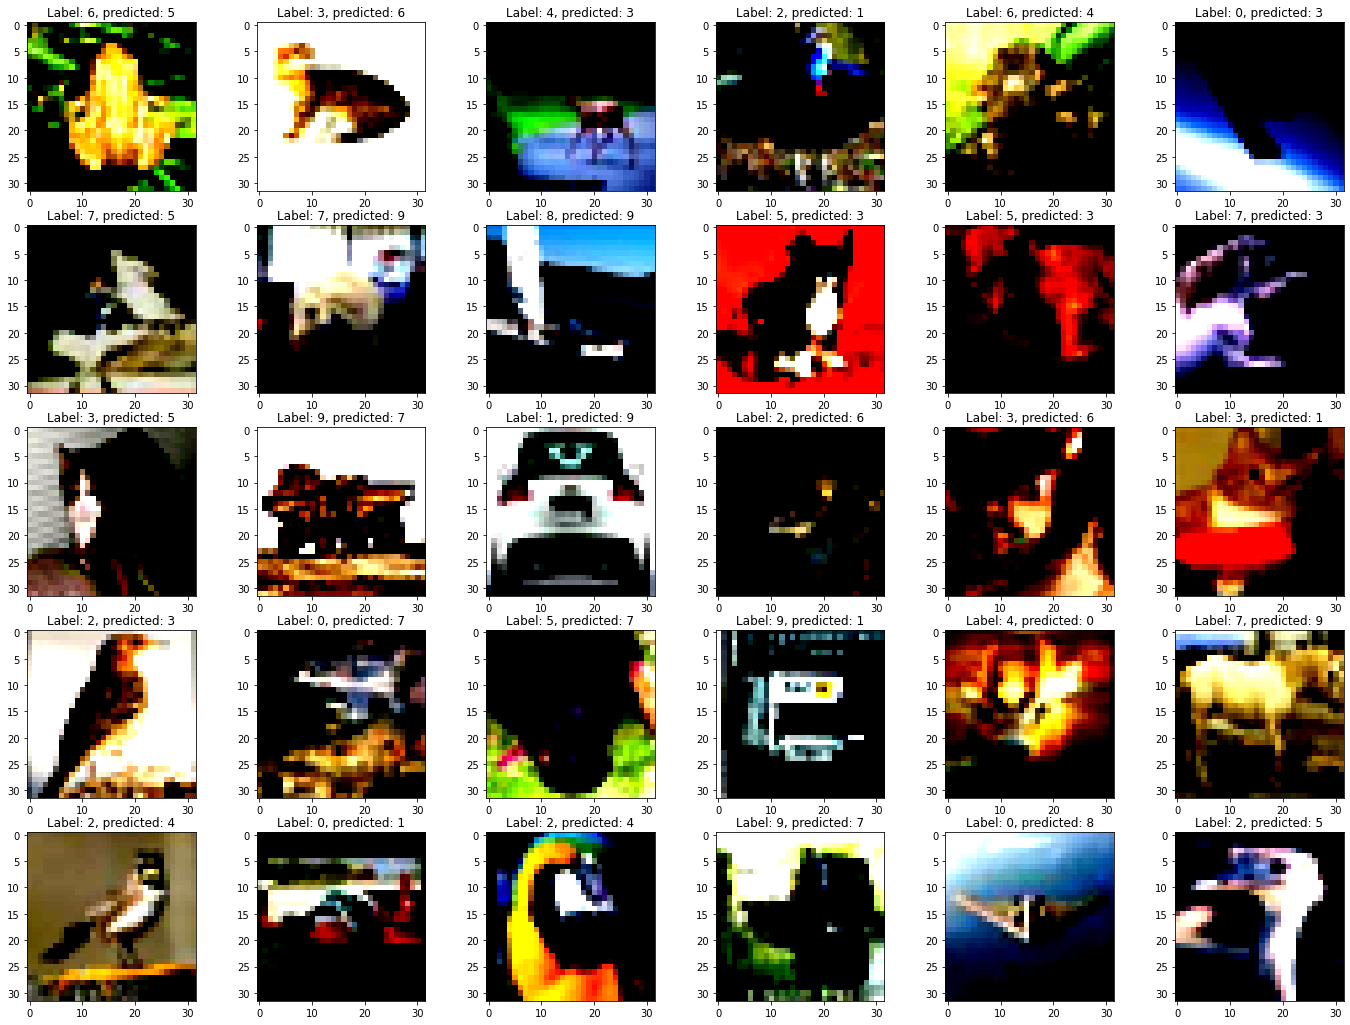

In [ ]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [6]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn(ishape=(32, 32, 3), d=1, k=10, lr=1e-3, drop=0.2):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_conv_0 = tf.keras.layers.Conv2D(32, 3, activation='relu', dilation_rate=d, padding='same')(model_input)
    model_conv_0_1 = tf.keras.layers.Conv2D(32, 3, activation='relu', dilation_rate=d, padding='same')(model_conv_0)
    model_pooling_0 = tf.keras.layers.MaxPool2D()(model_conv_0_1)
    model_conv_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', dilation_rate=d, padding='same')(model_pooling_0)
    model_conv_1_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', dilation_rate=d, padding='same')(model_conv_1)
    model_conv_1_2 = tf.keras.layers.Conv2D(64, 3, activation='relu', dilation_rate=d, padding='same')(model_conv_1_1)
    model_pooling_1 = tf.keras.layers.MaxPool2D()(model_conv_1_2)
    model_conv_2 = tf.keras.layers.Conv2D(128, 3, activation='relu', dilation_rate=d, padding='same')(model_pooling_1)
    model_conv_2_1 = tf.keras.layers.Conv2D(128, 3, activation='relu', dilation_rate=d, padding='same')(model_conv_2)
    model_conv_2_2 = tf.keras.layers.Conv2D(128, 3, activation='relu', dilation_rate=d, padding='same')(model_conv_2_1)
    model_pooling_2 = tf.keras.layers.MaxPool2D(pool_size=(8,8))(model_conv_2_2)
    model_conv_flatten = tf.keras.layers.Flatten()(model_pooling_2)
    model_dense_1 = tf.keras.layers.Dense(256, activation='relu')(model_conv_flatten)
    model_drop_1 = tf.keras.layers.Dropout(rate=drop)(model_dense_1)
    model_dense_2 = tf.keras.layers.Dense(256, activation='relu')(model_drop_1)
    model_drop_2 = tf.keras.layers.Dropout(rate=drop)(model_dense_2)
    out = tf.keras.layers.Dense(k, activation='softmax')(model_drop_2)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

## 6. Define your callbacks (save your model, patience, etc.)

In [7]:
model_name_cnn = "team_48_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [8]:
model = my_model_cnn()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928 

In [9]:
# train your model - decide for how many epochs
model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/1000
1172/1172 [==============================] - 332s 283ms/step - loss: 1.9369 - accuracy: 0.2453 - val_loss: 1.4292 - val_accuracy: 0.4594
Epoch 2/1000
1172/1172 [==============================] - 326s 278ms/step - loss: 1.3421 - accuracy: 0.5025 - val_loss: 1.1124 - val_accuracy: 0.5935
Epoch 3/1000
1172/1172 [==============================] - 324s 277ms/step - loss: 1.0925 - accuracy: 0.6112 - val_loss: 0.9983 - val_accuracy: 0.6430
Epoch 4/1000
1172/1172 [==============================] - 331s 283ms/step - loss: 0.9293 - accuracy: 0.6699 - val_loss: 0.9896 - val_accuracy: 0.6443
Epoch 5/1000
1172/1172 [==============================] - 332s 283ms/step - loss: 0.7448 - accuracy: 0.7364 - val_loss: 0.7989 - val_accuracy: 0.7175
Epoch 6/1000
1172/1172 [==============================] - 325s 277ms/step - loss: 0.6361 - accuracy: 0.7743 - val_loss: 0.8007 - val_accuracy: 0.7199
Epoch 7/1000
1172/1172 [==============================] - 327s 279ms/step - loss: 0.5471 - accuracy:

## 8. Test your model

313/313 [==============================] - 7s 22ms/step - loss: 0.7714 - accuracy: 0.7528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2472


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

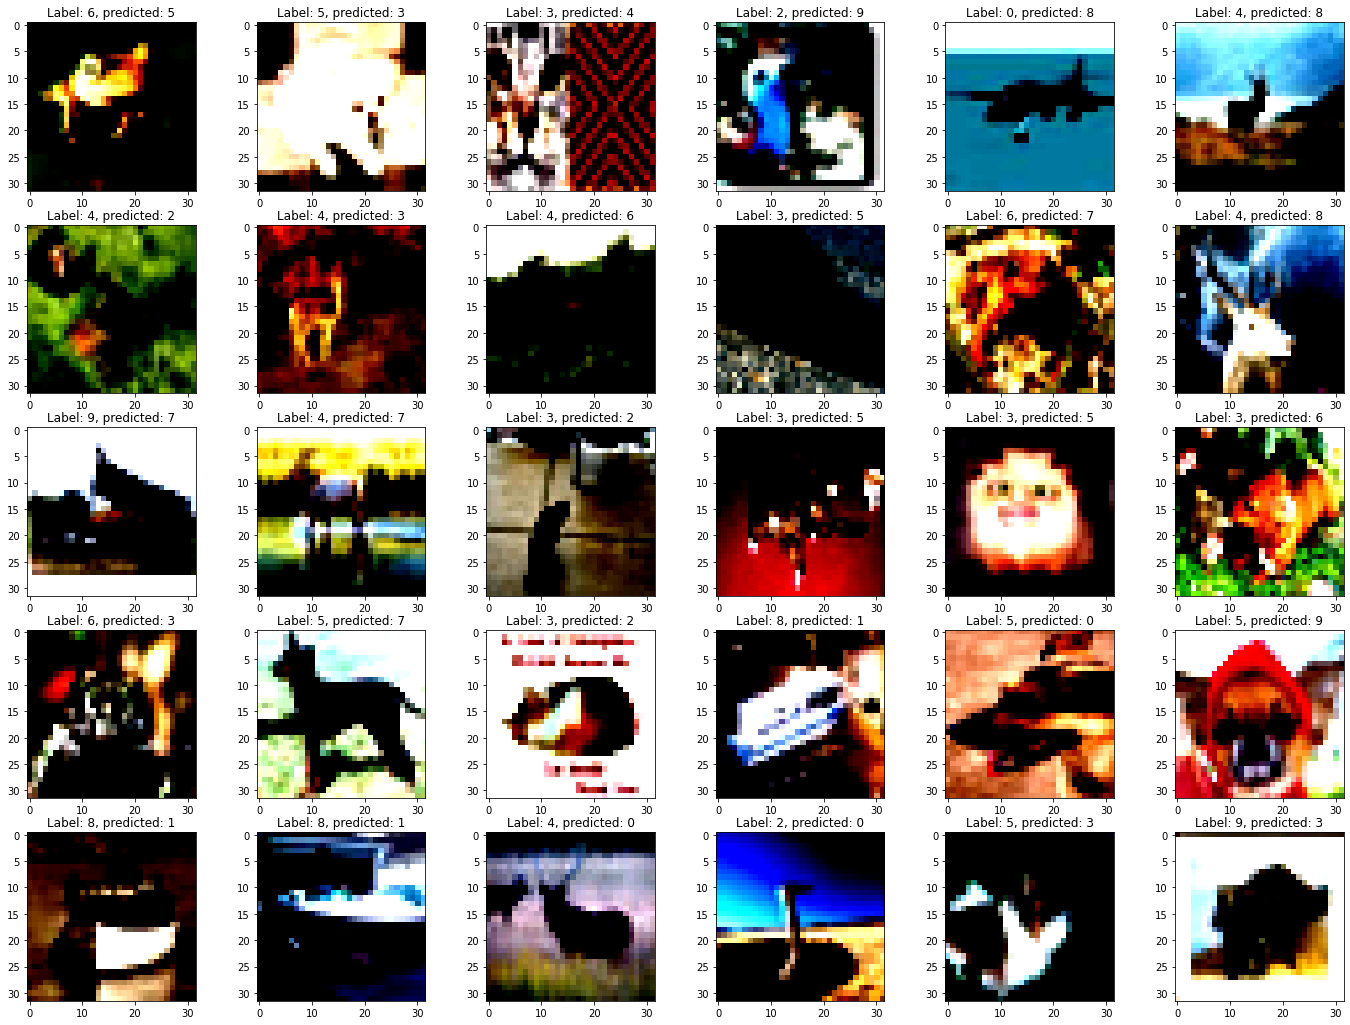

In [ ]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Do Trong Anh, Bright Anorchie, Aaron Joseph, Alan Joseph** helped design the model and write the code for fully connected model (**score 3**)
- **Do Trong Anh, Bright Anorchie, Aaron Joseph, Alan Joseph** helped design helped to implement the data augmentation module (**score 3**)
- ...